Here, you develop the E+M Runge-Kuttas. (You want to be able to graph two functions at a time. The plotting functions can handle it, but the other functions aren't built for it specifically because your cases are simple enough that the answer for the B field is proportional to the E Field.)

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
def Const(omega, x, sigma, mu, deriv, cellAve):
    degFreed = omega.degFreed
    k = 1
    ct = 0
    
    fact = 2.0 * np.pi * k
    u = np.arange(degFreed)# (1.0 / fact) * (cos(fact * (x[:-1] - ct)) - cos(fact * (x[1:] - ct)))
    return u

In [3]:
nh_min = 128
refRatio = 2
CFL = np.sqrt(0.5)
nt = 25
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'U'
RK = 4
order = 2

L = 1
locs = [x_1]
epsilons = [0.5, 0.5] # [1, 1]
mus = [0.5, 0.5] # [1, 1]

func = WFT.GaussPacket
mode = 23

In [4]:
if (RK == 1):
    TimeIntegratorFunc = ST.ForwardEuler
else:
    if (RK == 2):
        TimeIntegratorFunc = ST.MidpointMeth
    else:
        TimeIntegratorFunc = ST.RK4

if (deriv == 'U'):
    # DiffMatFunc = OT.Upwind1D
    DiffFunc = TT.Upwind#ST.Upwind
else:
    # DiffMatFunc = OT.CenterDiff1D
    DiffFunc = TT.CenterDiff#ST.CenterDiff

In [5]:
def Block(matrica, var = 1):
    matricaList = [matrica for k in range(var)]
    matrice = block_diag(*matricaList)
    return matrice

In [6]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

In [7]:

physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
cAMR = physicsAMR.cVec
cMatAMR = physicsAMR.cMat

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cC = physicsC.cVec
cMatC = physicsC.cMat

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cF = physicsF.cVec
cMatF = physicsF.cMat

c = cC[0]

In [8]:
def ExpandMat(mat):
    errorLoc = 'ERROR:\nOperatorTools:\nExpandMat:\n' # Don't know where we're putting this yet.
    errorMess = ''
    shape = np.shape(mat)
    if (len(shape) != 2):
        errorMess = 'mat must be a rank-2 matrix!'
    
    else:
        if (shape[0] != shape[1]):
            errorMess = 'mat must be a square matrix!'
    if (errorMess != ''):
        sys.exit(errorLoc + errorMess)
    
    size_min = shape[0]
    size_max = 2 * size_min
    newMat = np.zeros((size_max, size_max), int)
    newMat[0:size_max:2, 0:size_max:2] = mat
    newMat[1:size_max + 1:2, 1:size_max + 1:2] = mat
    return newMat

In [9]:
# Creates anti-block-diagonal matrix 
def ConvertOp(omega, physics):
    degFreed = omega.degFreed
    cMat = physics.cMat
    cVec = physics.cVec
    c = cVec[0]
    cVecs = np.asarray(np.append(cVec, -cVec))
    
    # eigVals = #[item for sublist in zip(cVec, -cVec) for item in sublist]
    I = np.eye(degFreed)
    normConst = 1. #  / np.sqrt(c**2 + 1)
    op = normConst * np.asarray(np.block([[cMat, cMat], [-I, I]]))
    diagMat = np.diag(cVecs)
    return op, diagMat

If  
$v_{j}^{s} = \frac{E_{j}^{s} - c B_{j}^{s}} {2 c}$  
and  
$v_{n + j}^{s} = \frac{E_{j}^{s} + c B_{j}^{s}}{2 c}$  
and  
$B_{j}^{0} = E_{j}^{0}$,  
then  
$c \Delta t \frac{\partial v_{j}^{0}}{\partial x} = \sigma_{CFL} \frac{1 - c}{2 c} (E_{j + 1}^{0} - E_{j}^{0})$  
and  
$c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x} = \sigma_{CFL} \frac{1 + c}{2 c} (E_{j}^{0} - E_{j - 1}^{0})$.  
  
If  
$v_{j}^{1} = v_{j}^{0} + c \Delta t \frac{\partial v_{j}^{0}}{\partial x}$  
and  
$v_{n + j}^{1} = v_{n + j}^{0} - c \Delta t \frac{\partial v_{n + j}^{0}}{\partial x}$,  
then  
$v_{j}^{1} = \frac{1 - c}{2 c} [(1 - \sigma_{CFL}) E_{j}^{0} + \sigma_{CFL} E_{j + 1}^{0}]$  
and  
$v_{n + j}^{1} = \frac{1 + c}{2 c} [(1 - \sigma_{CFL}) E_{j}^{0} + \sigma_{CFL} E_{j - 1}^{0}]$. 
  
If  
$E_{j}^{s} = c (v_{j}^{s} + v_{n + j}^{s})$  
and  
$B_{j}^{s} = v_{n + j}^{s} - v_{j}^{s}$,  
then  
$E_{j}^{1} = (1 - \sigma_{CFL}) E_{j}^{0} + \frac{\sigma_{CFL}}{2} [(1 + c) E_{j - 1}^{0} + (1 - c) E_{j + 1}^{0}]$  
and  
$B_{j}^{1} = (1 - \sigma_{CFL}) E_{j}^{0} + \frac{\sigma_{CFL}}{2 c} [(1 + c) E_{j - 1}^{0} - (1 - c) E_{j + 1}^{0}]$.  


In [10]:
def Check(omega, physics, CFL, u0stack, v_i, v_f, u_f, op):
    
    degFreed = omega.degFreed
    nh_min = omega.nh_min
    c = physics.cVec[0]
    cMat = physics.cMat
    roundFact = 15
    
    I = np.eye(degFreed)
    dx, dt = ST.FindDxDt(omega, CFL, cMat)
    print('')
    print('')
    print('After 1 Forward Euler timestep on a uniform grid:')
    print('')
    print('The derivative of v should be')
    uShiftM = np.roll(u0stack, 1)
    uShiftP = np.roll(u0stack, -1)
    alpha_min = (1. - c) / (2 * c)
    alpha_plu = (1. + c) / (2 * c)
    derivShould1 = alpha_min * CFL * (uShiftP - u0stack)
    derivShould2 = -alpha_plu * CFL * (u0stack - uShiftM)
    derivShould = np.round(np.asarray(np.append(derivShould1[:degFreed], derivShould2[degFreed:])), roundFact)
    print(derivShould)
    print('In actuality, it is')
    derivres = np.round(dt * op @ v_i, roundFact)
    print(derivres)
    print('This is off by a factor of')
    r1 = np.round([derivShould[i] / derivres[i] for i in range(len(derivres))], 12)
    print(r1)
    indices1 = np.where(r1 != 1)
    print('Indices:', indices1[0])
    print('Factors:', r1[indices1[0]])
    print('')
    print('v itself should be')
    shouldbe1 = alpha_min * (((1. - CFL) * u0stack) + (CFL * uShiftP))
    shouldbe2 = alpha_plu * (((1. - CFL) * u0stack) + (CFL * uShiftM))
    shouldbe = np.round(np.asarray(np.append(shouldbe1[:degFreed], shouldbe2[degFreed:])), roundFact)
    print(shouldbe)
    print('In actuality, it is')
    v_f1 = np.round(v_f, roundFact)
    print(v_f1)
    print('This is off by a factor of')
    r = np.round([shouldbe[i] / v_f1[i] for i in range(len(v_f))], roundFact)
    print(r)
    indices = np.where(r != 1)
    print('Indices:', indices[0])
    print('Factors:', r[indices[0]])
    print('')
    print('u should be')
    u1 = ((1. - CFL) * u0stack) + ((CFL / 2) * (((1 + c) * uShiftM) + ((1 - c) * uShiftP)))
    u2 = ((1. - CFL) * u0stack) + ((CFL / (2 * c)) * (((1 + c) * uShiftM) - ((1 - c) * uShiftP)))
#     for i in range(nt):
#         u1 = ST.RungeKutta(omega, physics, I, u0stack[:degFreed], 1, CFL, RK, op = -op[:degFreed, :degFreed])
#         u2 = ST.RungeKutta(omega, physics, I, u0stack[degFreed:], 1, CFL, RK, op = -op[:degFreed, :degFreed])
    u = np.round(np.asarray(np.append(u1[:degFreed], u2[degFreed:])), roundFact)
    print(u)
    print('In actuality, it is')
    u_f1 = np.round(u_f, roundFact)
    print(u_f1)
    print('This is off by a factor of')
    r2 = np.round([u[i] / u_f1[i] for i in range(len(u_f))], roundFact)
    print(r2)
    indices2 = np.where(r2 != 1)
    print('Indices:', indices2[0])
    print('Factors:', r2[indices2[0]])
    return

In [11]:
#   WaveEqRK(omega, physics, waves, u0, nt, CFL, RK, deriv) deriv will be upwind, center, or exact.
def WaveEqRK(omega, physics, waves, u0, nt, CFL, RK, derivOp, left = True):
    # Unpack requisite attributes.
    degFreed = omega.degFreed
    cMat = physics.cMat
    c = cMat[0, 0]
    
    # Stack the initial condition.
    u0stack = np.asarray(np.append(u0, u0 / c)) # I'm not sure how to relate the initial condition for the E and B fields.
    
    # Create change of basis matrix.
    convertOp, diagMat = ConvertOp(omega, physics)
    convertOpinv = LA.inv(convertOp)
    
    # Change basis of initial condtion.
    v = np.asarray(convertOpinv @ u0stack)
    v_i = v.copy()
    
    # Turn difference matrix into block diagonal.
    # THIS IS SCOTCH TAPE.
    derivMat = OT.Block([-derivOp.transpose(), derivOp]) # ExpandMat(derivOp)
    
    # Create identity matrix to appease the current structure of my RK function.
    I = np.eye(2 * degFreed)
    
    # Turn Fourier matrix into block diagonal.
    wavesMat = OT.Block(waves, var = 2)
    
    # Create operator to pass into RK function.
    op = diagMat @ derivMat

    for i in range(nt):
        v = ST.RungeKutta(omega, physics, I, v, 1, CFL, RK, op = op)
    
    # Convert v back to space-space.
    u = convertOp @ v

    # Convert u to k space.
    fCoefs = LA.inv(wavesMat) @ u
    
    # Run check.
    Check(omega, physics, CFL, u0stack, v_i, v, u, op)
    
    return fCoefs, v


In [12]:
op, diagMat = ConvertOp(omegaC, physicsC)

# print(op)
print(LA.inv(op))

[[ 0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0

In [13]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omegaAMR, CFL, cMatAMR, nt = nt)
mu, sigma = WFT.GaussParams(x_0, x_1)
args = [mu, sigma, mode]
wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

derivMat = TT.ExactSpatOp(omegaAMR)
spatOp = -cMatF @ derivMat
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -cMatC @ derivMatC
timePropOpC = LA2.expm(t * spatOpC)

You are using ExactSpatOp in TestTools module!
You are using ExactSpatOp in TestTools module!


In [14]:
# wavesAMR = OT.Block(wavesAMR, var = 2)
# nullspace = OT.Block(nullspace, var = 2)
# restrictOp = OT.Block(restrictOp, var = 2)
# wavesC = OT.Block(wavesC, var = 2)
# wavesF = OT.Block(wavesF, var = 2)

opC = OT.SpaceDeriv(omegaC, order, deriv)#-cMatC @ OT.SpaceDeriv(omegaC, order, diff)
opF = OT.SpaceDeriv(omegaF, order, deriv)#-cMatF @ OT.SpaceDeriv(omegaF, order, diff)
opAMR = OT.SpaceDeriv(omegaAMR, order, deriv)#-cMatAMR @ OT.SpaceDeriv(omegaAMR, order, diff)

In [15]:
# For Gaussian:
waveInitC = WFT.InitCond(omegaC, physicsC, func, args)
# waveInitC = np.append(waveInitC, waveInitC)
waveInitF = WFT.InitCond(omegaF, physicsF, func, args)
# waveInitF = np.append(waveInitF, waveInitF)

FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsC1 = np.asarray(np.append(FCoefsC, FCoefsC / c))
FCoefsF1 = np.asarray(np.append(FCoefsF, FCoefsF / c))

# Find initial waveform on coarse, fine, and AMR grids.
waveInitC = wavesC @ FCoefsC
waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
FCoefsAMR1 = np.asarray(np.append(FCoefsAMR, FCoefsAMR / c))

wavePropC = WFT.WaveEq(omegaC, physicsC, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC
wavePropF = WFT.WaveEq(omegaF, physicsF, func, args, t)
wavePropAMR = WFT.WaveEq(omegaAMR, physicsAMR, func, args, t)#FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC)
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF)
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)
FCoefsPropC1 = np.asarray(np.append(FCoefsPropC, FCoefsPropC / c))
FCoefsPropF1 = np.asarray(np.append(FCoefsPropF, FCoefsPropF / c))
FCoefsPropAMR1 = np.asarray(np.append(FCoefsPropAMR, FCoefsPropAMR / c))

# TEST FOR EXACT GAUSSIAN AT NEW LOCATION.

# solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
# solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, op = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
# solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, op = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

solverCoefsC, vC = WaveEqRK(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, derivOp = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF, vF = WaveEqRK(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, derivOp = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR, vAMR = WaveEqRK(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, derivOp = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)

u1 = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = -cMatC @ opC)
u2 = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = -cMatC @ opC)
doubleSolvCoefsC = np.asarray(np.append(u1, u2))


allCoefsC = PT.Load(FCoefsC1, FCoefsPropC1, solverCoefsC)#, doubleSolvCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF1, FCoefsPropF1, solverCoefsF)#, FCoefsPropFTh)
# allCoefsAMR = nullspace @ PT.Load(FCoefsAMR1, FCoefsPropAMR1, solverCoefsAMR)#, FCoefsPropAMRTh)




labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']#, 'Naively RK-Propagated Wave']#, 'Rotation Matrix Propagated Wave']


We're doing BoolesAve!
x is 513 long.
We're doing BoolesAve!
x is 1025 long.
We're doing BoolesAve!
x is 513 long.
We're doing BoolesAve!
x is 1025 long.
We're doing BoolesAve!
x is 769 long.


After 1 Forward Euler timestep on a uniform grid:

The derivative of v should be
[-3.00000000e-14 -2.21000000e-13 -1.05400000e-12 -2.27700000e-12  1.21750000e-11  1.63503000e-10  9.90853000e-10  3.84442400e-09  8.14092700e-09 -1.01434840e-08 -1.78693440e-07 -8.87917244e-07 -2.74047405e-06 -4.97050880e-06  4.37888414e-07  3.98161881e-05  1.60825266e-04  3.84187634e-04  5.48622214e-04  9.06900381e-05 -1.93207771e-03 -6.04574960e-03 -1.06816849e-02 -1.09193238e-02 -2.74532150e-04  2.31745628e-02  5.00438260e-02  6.04531681e-02  3.70574558e-02 -1.73747767e-02 -7.49199624e-02 -9.95934203e-02 -7.49199624e-02 -1.73747767e-02  3.70574558e-02  6.04531681e-02  5.00438260e-02  2.31745628e-02 -2.74532150e-04 -1.09193238e-02 -1.06816849e-02 -6.04574960e-03 -1.93207771e-03  9.06900381e-05  5.48622214e-04  3.8

[      -inf       -inf       -inf       -inf        inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        inf        inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        inf        inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        inf        inf        inf        inf        inf       -inf       -inf       -inf       -inf       -inf        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        nan        na

/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/Users/sashacurcic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars




After 1 Forward Euler timestep on a uniform grid:

The derivative of v should be
[-3.00000000e-15 -1.10000000e-14 -3.40000000e-14 -9.20000000e-14 -2.24000000e-13 -4.86000000e-13 -9.13000000e-13 -1.35100000e-12 -9.40000000e-13  3.19900000e-12  1.88900000e-11  6.45970000e-11  1.78923000e-10  4.32869000e-10  9.37056000e-10  1.81926300e-09  3.11331500e-09  4.44115900e-09  4.28635100e-09 -1.42521400e-09 -2.17228310e-08 -7.39999580e-08 -1.87665084e-07 -4.05507499e-07 -7.77158635e-07 -1.33458040e-06 -2.03463723e-06 -2.65119466e-06 -2.60399304e-06 -7.31394695e-07  4.94260079e-06  1.73251395e-05  4.00396246e-05  7.65746654e-05  1.28461730e-04  1.92253528e-04  2.55406346e-04  2.91776751e-04  2.58283723e-04  9.51630702e-05 -2.67231155e-04 -8.92464250e-04 -1.81199594e-03 -2.99150100e-03 -4.29649794e-03 -5.46890772e-03 -6.12905018e-03 -5.81650868e-03 -4.07657755e-03 -5.86493870e-04  4.70049251e-03  1.14303374e-02  1.87879413e-02  2.55420189e-02  3.02156643e-02  3.13700593e-02  2.79505683e-02  1.9

[           -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf             inf             inf             inf             inf             inf             inf             inf             inf             inf             inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf             inf             inf             inf             inf             inf             inf             inf             inf             inf             inf             inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf            -inf             inf             inf             inf             inf             inf             inf             inf             inf             inf        

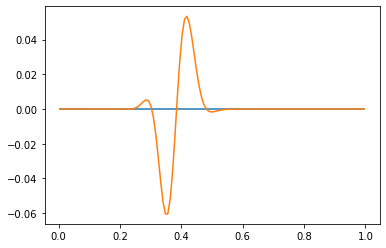

In [16]:
xC = omegaC.xCell
plt.figure()
plt.plot(xC, vC[:nh_min])
plt.plot(xC, vC[nh_min:])
plt.show()

In [17]:
actual = np.round(FCoefsPropC1, 12)[nh_min:]
solver = np.round(solverCoefsC, 12)[nh_min:]

print(actual)
print(solver)
print(actual.transpose() @ actual)
print(solver.transpose() @ solver)
print('')

[ 0.00000000e+00 -9.73194092e-04 -2.10048032e-03 -3.12980674e-03  3.69295093e-03  7.47684025e-03  2.06260054e-03 -1.83243195e-03 -1.10247655e-02 -1.24949911e-02  8.52226326e-03  1.67552776e-02  1.00058608e-02  2.51788515e-03 -2.40147772e-02 -2.71685054e-02  9.28797143e-03  2.27025118e-02  2.37294398e-02  1.31923932e-02 -3.36495826e-02 -3.82117106e-02  2.30463028e-03  1.85061192e-02  3.43542602e-02  2.29482015e-02 -3.06419159e-02 -3.53607692e-02 -7.49738256e-03  7.32697898e-03  3.20212095e-02  2.27178508e-02 -1.75884948e-02 -2.14735092e-02 -1.11275829e-02 -8.66323944e-04  1.95755856e-02  1.41340459e-02 -5.80406758e-03 -8.41155458e-03 -7.79342495e-03 -2.55349462e-03  7.87928141e-03  5.71631539e-03 -6.92043847e-04 -2.02800332e-03 -3.27566762e-03 -1.36494718e-03  2.07173019e-03  1.52069111e-03  2.27796063e-04 -2.58048070e-04 -8.80185904e-04 -3.96225591e-04  3.46857251e-04  2.65939740e-04  1.18080252e-04 -2.47776700e-06 -1.54724303e-04 -7.13234780e-05  3.44433150e-05  3.01661420e-05  2.4747

Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttemptc2E.
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttemptc2EB.


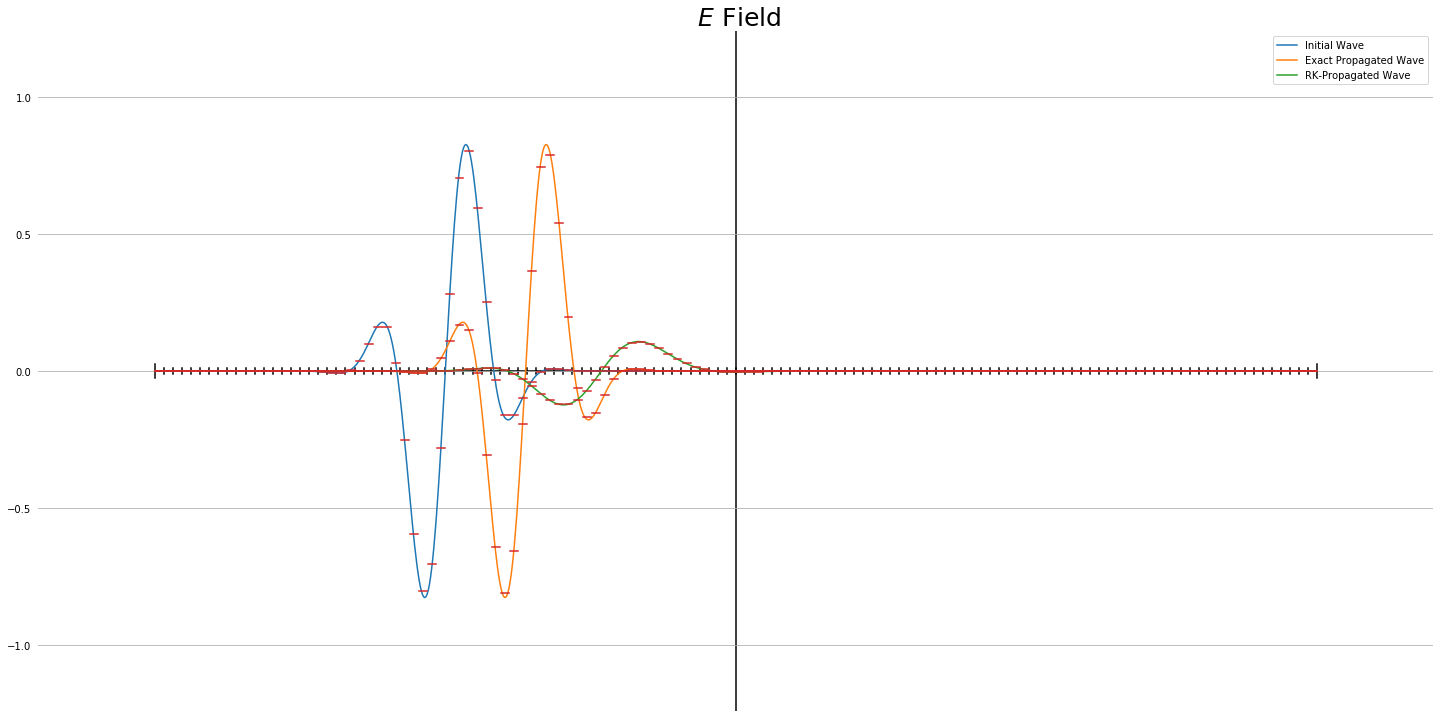

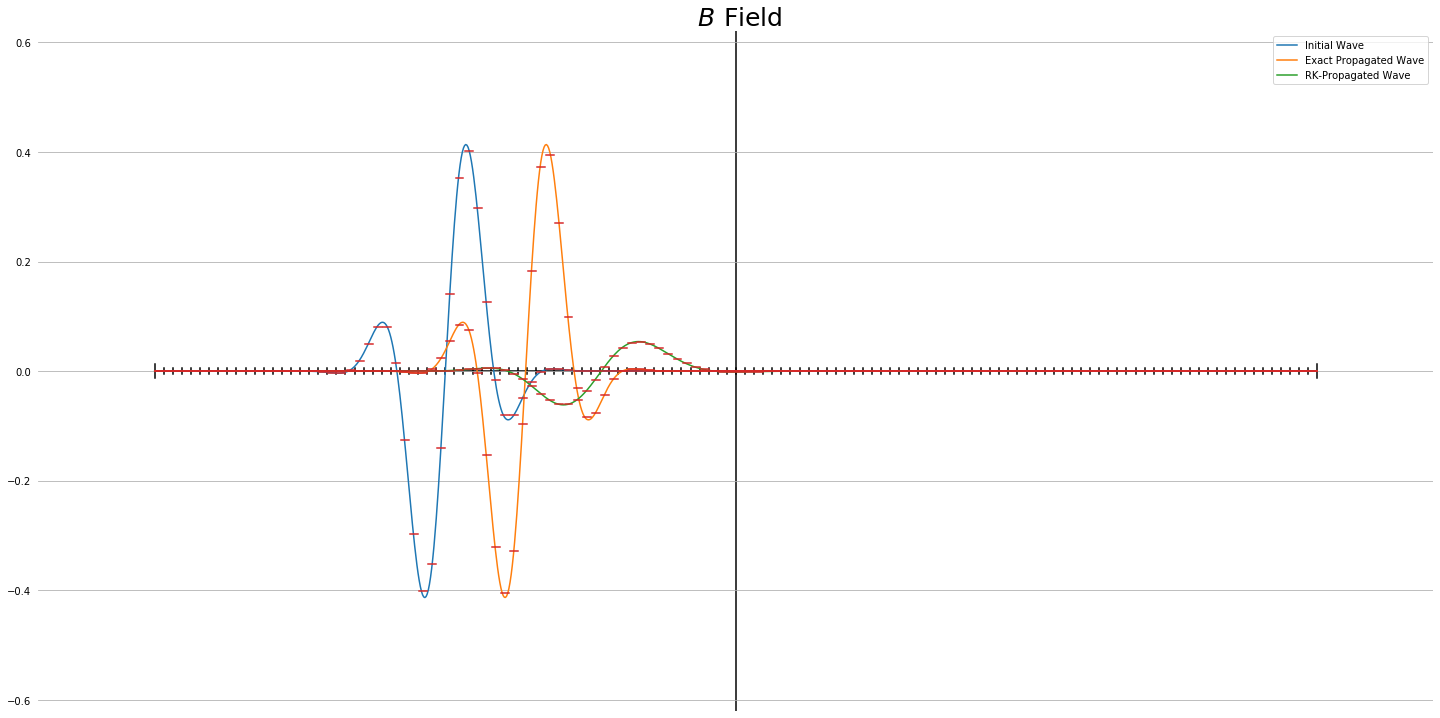

In [18]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, saveName = 'RKWaveEqAttemptc2')#, saveName = 'Coarse', dpi = 300)
# PT.PlotMixedWave(omegaF, physicsF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
# PT.PlotMixedWave(omegaAMR, physicsAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttempt25E.
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/RKWaveEqAttempt25EB.


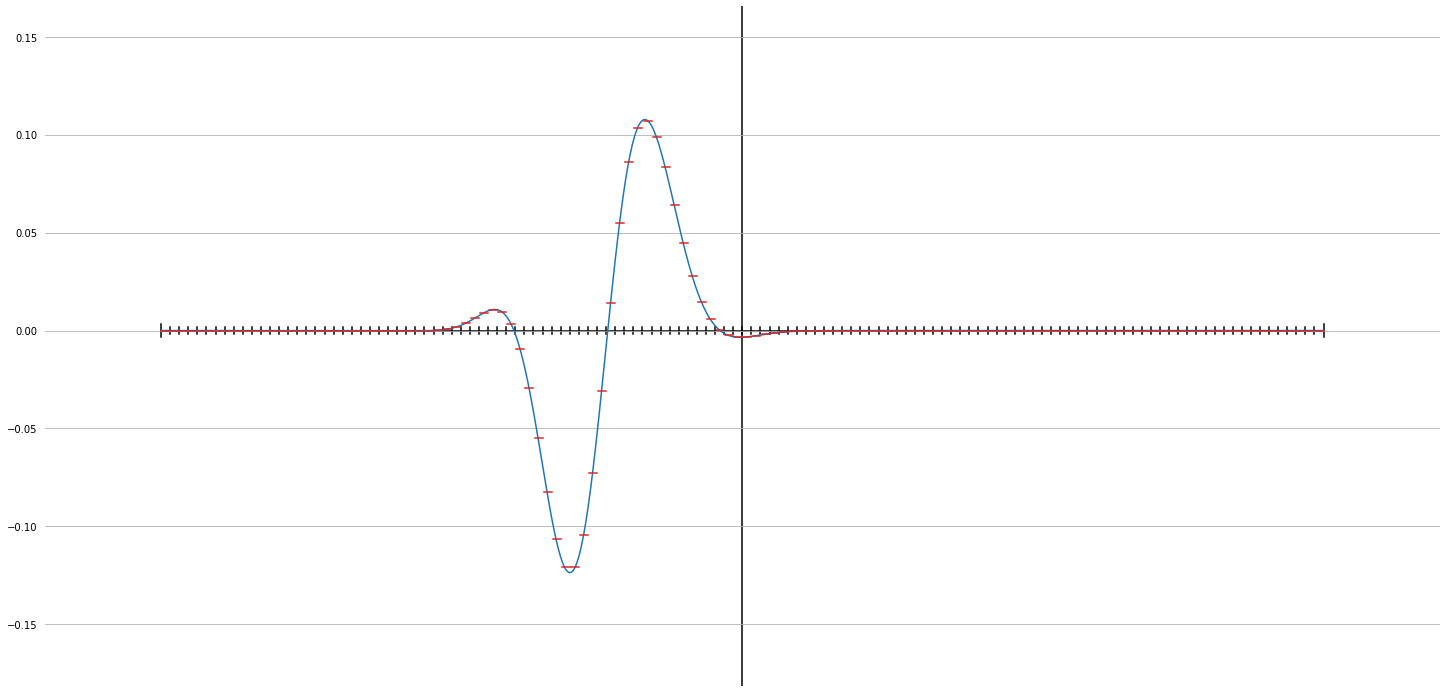

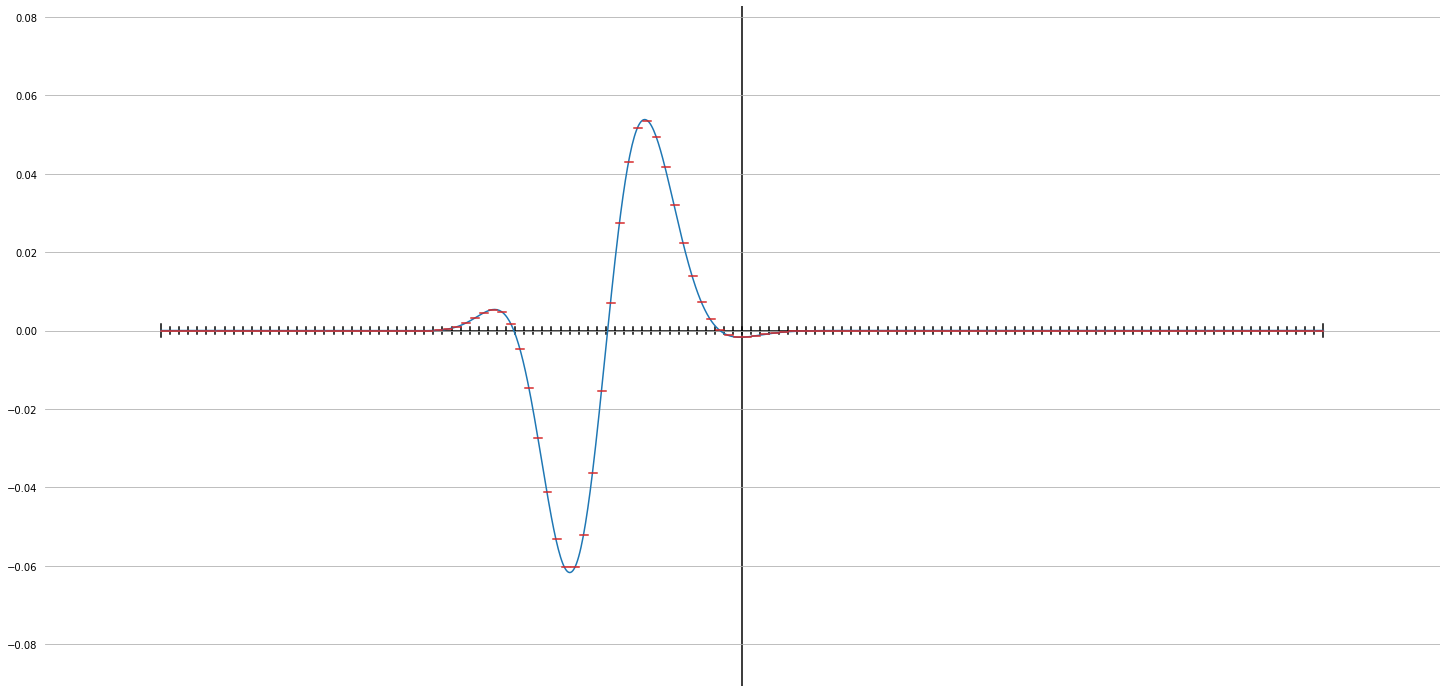

In [19]:
PT.PlotMixedWave(omegaC, physicsC, waves = wavesC, FCoefs = solverCoefsC, rescale = 5, yGrid = True, saveName = 'RKWaveEqAttempt' + str(nt))#, saveName = 'Coarse', dpi = 300)


In [20]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.
# I see that I can't use the rotation matrix to propagate the matrices. I'm pretty sure that my Fourier-propagated logic is wrong, though.
# 2nd-order polynomial interp is working BETTER THAN 3rd-order for RK4 center diff.
# How do I employ Fourier transforms on Maxwell's Equations?


In [21]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.


In [22]:
waveMat = OT.Block(wavesC, var = 2)
solvRes = waveMat @ solverCoefsC
print(solvRes[:nh_min])
print(solvRes[nh_min:])
print('')

[-4.77048956e-18 -2.36356074e-17 -1.58835618e-17  1.21430643e-17  1.38777878e-17  4.85722573e-17  3.22658567e-16  8.88178420e-16 -1.73472348e-15 -4.13419299e-14 -3.10099169e-13 -1.60350205e-12 -6.23081448e-12 -1.71402198e-11 -1.94708850e-11  1.20307816e-10  1.02506293e-09  4.79980936e-09  1.67649667e-08  4.57390569e-08  9.23080087e-08  9.44450205e-08 -2.31596670e-07 -1.73217278e-06 -6.32540607e-06 -1.73040398e-05 -3.82657126e-05 -6.83892355e-05 -9.11263168e-05 -5.49129329e-05  1.49686664e-04  7.01331509e-04  1.82087539e-03  3.67564929e-03  6.20217430e-03  8.87945658e-03  1.05473600e-02  9.41180454e-03  3.36660122e-03 -9.33826601e-03 -2.92237364e-02 -5.48171539e-02 -8.23784198e-02 -1.06392371e-01 -1.20828931e-01 -1.20837624e-01 -1.04306569e-01 -7.27065452e-02 -3.08812950e-02  1.41646113e-02  5.50627024e-02  8.58590999e-02  1.03230742e-01  1.06849432e-01  9.89249787e-02  8.32123412e-02  6.38724255e-02  4.45271485e-02  2.77026604e-02  1.46877988e-02  5.71046779e-03  2.80255754e-04 -2.4450

In [23]:
dx, dt = ST.FindDxDt(omegaC, CFL, cMatC)
print(dt)

0.0027621358640099515


In [24]:
c = cC[0]
alpha_min = 1. - c
alpha_plu = 1. + c
print(CFL * alpha_min)
print(CFL * alpha_plu)
print('')


-0.7071067811865476
2.121320343559643



In [25]:
# print(-3.7123106 / 0.53033009)

print(-1.23743687 / 0.1767767)
print(-4.94974747 / 0.70710678)
print(CFL / 0.1767767)

-6.999999830294377
-7.0000000141421355
3.9999998935750445


In [26]:
print(dt/CFL)
print(opC)
print('')
print(cMatC @ opC)
print('')
print(((dt * cMatC) / CFL) @ opC)

0.00390625
[[ 128.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. -128.]
 [-128.  128.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 

[[ 256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. -256.]
 [-256.  256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.

In [27]:
thisWay = OT.Block([-cMatC @ opC, cMatC @ opC])
cMats = OT.Block([-cMatC, cMatC])
derivMats = OT.Block(opC, var = 2)
thatWay = cMats @ derivMats
print(thisWay)
print('')
print(thatWay)
print('')


[[-256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

[[-256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  256.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [28]:
print(np.shape(waveInitC[nh_min:]))
print('')

(0,)

